In [6]:
# Import packages

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib as plt
import matplotlib.pyplot as plt
import scipy.io
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import StratifiedGroupKFold
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from tensorflow.keras.layers import Conv1D, MaxPool1D, Flatten, Dense, Dropout, BatchNormalization, MaxPooling1D, Input, LeakyReLU, AveragePooling1D
import tensorflow
import os
import pydot
from tensorflow import random
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adamax
from tensorflow.keras.models import Model 
from sklearn.model_selection import train_test_split
from pathlib import PurePosixPath as PPP 

In [7]:
pathCutData = "P:/matlab/resprog/GUI/CleanCutsDL/"  # Path to the directory where the data (mat-file) is located
fileCutData = 'cutDataCinCTTI_rev_v2.mat'           # Name of the mat-file, containing the data

matCutData = scipy.io.loadmat(pathCutData + fileCutData, squeeze_me=True, struct_as_record=False) # Load the data

In [8]:
cutData = matCutData['data'] # The data

dataLabels = cutData[0]._fieldnames.copy() # Data labels

dataMatrix = []*len(dataLabels)

# Append the data to list
for dataIndex in range(len(dataLabels)):
    dataMatrix.append([])
    for n in range(cutData.size):
        dataMatrix[dataIndex].append( getattr(cutData[n], dataLabels[dataIndex]) )

# Make shockable list
# if 1: shock, if 0: non shock
shockable = []
dataLabels.append('Shockable')

for i in range(len(dataMatrix[4])):
    if dataMatrix[4][i] > 3:
        shockable.append(1)
    else:
        shockable.append(0)
        
# List containing patient ID, ECG-signal, shockable lable and class lable, respectivily
dataDfMatrix = list(zip(dataMatrix[1], dataMatrix[5], shockable, dataMatrix[4]))

df_data = pd.DataFrame(dataDfMatrix, columns=range(4)) #dataLabels

df_data.head(-1)

,0,1,2,3
0,1,"[-0.287649, -0.264967, -0.242285, -0.219603, -...",1,4
1,1,"[-0.079387, -0.078356, -0.07217, -0.075263, -0...",0,1
2,1,"[-0.040209, -0.040209, -0.038147, -0.039178, -...",0,1
3,1,"[0.021651, 0.018558, 0.017527, 0.014434, 0.017...",0,1
4,1,"[-0.090728, -0.089697, -0.090728, -0.089697, -...",0,1
...,...,...,...,...
2827,100,"[-0.070108, -0.077325, -0.08144900000000001, -...",1,4
2828,100,"[0.042271, 0.040209, 0.038147, 0.034023, 0.032...",1,4
2829,100,"[-0.104131, -0.097945, -0.09279, -0.088666, -0...",0,2
2830,100,"[0.221665, 0.207231, 0.203107, 0.187642, 0.182...",0,2


In [9]:
unique, count = np.unique(df_data[3], return_counts=True)
print('The number of occurances of each class in the dataset = %s ' % dict (zip(unique, count) ), '\n' )

The number of occurances of each class in the dataset = {1: 423, 2: 912, 3: 689, 4: 643, 5: 166}  



In [10]:
# Shorten the number of signals in classes to be same length
classes, classCount = np.unique(df_data[3], return_counts=True)
minClassVal = min(classCount)

df_class_1 = df_data[df_data[3]==1].sample(n = minClassVal)
df_class_2 = df_data[df_data[3]==2].sample(n = minClassVal)
df_class_3 = df_data[df_data[3]==3].sample(n = minClassVal)
df_class_4 = df_data[df_data[3]==4].sample(n = minClassVal)
df_class_5 = df_data[df_data[3]==5].sample(n = minClassVal)

df_data_new = pd.concat([df_class_1, df_class_2, df_class_3, df_class_4, df_class_5], ignore_index=True)

df_data_new.head()

,0,1,2,3
0,57,"[-0.009279, 0.007217, 0.004124, -0.016496, -0....",0,1
1,67,"[-0.03093, -0.07217, -0.07217, -0.038147, -0.0...",0,1
2,55,"[0.016496, 0.016496, 0.017527, 0.022682, 0.022...",0,1
3,56,"[0.022682, 0.02062, 0.005155, -0.0030930000000...",0,1
4,13,"[0.107224, 0.116503, 0.129906, 0.1195960000000...",0,1


In [11]:
unique, count = np.unique(df_data_new[3], return_counts=True)
print('The number of occurances of each class in the dataset = %s ' % dict (zip(unique, count) ), '\n' )

The number of occurances of each class in the dataset = {1: 166, 2: 166, 3: 166, 4: 166, 5: 166}  



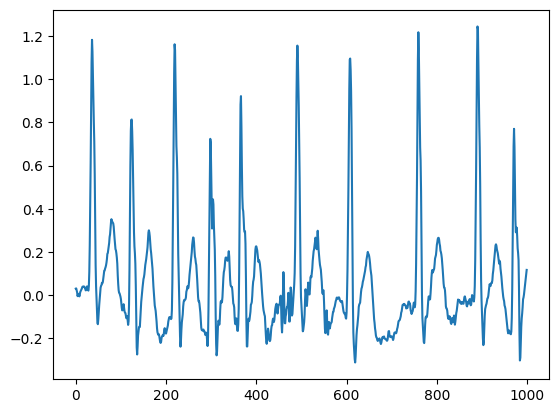

In [12]:
# Plot a random signal
sig = 100
y = df_data.iat[sig,1]
x = range(len(y))

plt.plot(x,y)

In [29]:
# stratified-group-10-fold to split the data-set in train-, validation- and test-set

sgkf = StratifiedGroupKFold(n_splits=10)
data_x = tf.stack(df_data_new[1]).numpy()
data_y = tf.stack(df_data_new[2]).numpy()
data_cat = tf.stack(df_data_new[3]).numpy()
groups = tf.stack(df_data_new[0]).numpy()

# Get the validation set
sgkfSplit = sgkf.split(data_x.tolist(), data_cat.tolist(), groups = groups.tolist())

for temp_index, val_index in sgkfSplit:
    tempIndex, valIndex = groups[temp_index], groups[val_index]
    temp, val = data_x[temp_index], data_x[val_index]
    temp_cat, val_cat = data_cat[temp_index], data_cat[val_index]

# Get the train- and test-set
sgkfSplit = sgkf.split(temp.tolist(), temp_cat.tolist(), groups = tempIndex.tolist())

for train_index, test_index in sgkfSplit:
    trainIndex, testIndex = tempIndex[train_index], tempIndex[test_index]
    train, test = temp[train_index], temp[test_index]
    train_cat, test_cat = temp_cat[train_index], temp_cat[test_index]


ecgLen = train.shape[1] # The length of each ECG-signal

In [30]:
# Model for the four-layer CNN experiment - padding and stride

def PSP_CNN(input_shape, pad, strd, pool):
    nfilters = [32,32,32,32]
    kernel_size = [1, 1, 1, 1]
    model_CNN = keras.Sequential()
    model_CNN.add(keras.Input(shape=input_shape))

    if pad == 1:
        if strd == 1:
            for i in range(len(nfilters)):
                model_CNN.add(keras.layers.Conv1D(
                    kernel_size=kernel_size[i], 
                    filters=nfilters[i], 
                    padding='same',
                    strides = 2,
                    activation = 'relu'))
                model_CNN.add(keras.layers.BatchNormalization())
        else:
            if pool == 1:
                for i in range(len(nfilters)):
                    model_CNN.add(keras.layers.Conv1D(
                        kernel_size=kernel_size[i], 
                        filters=nfilters[i], 
                        padding='same',
                        activation = 'relu'))
                    model_CNN.add(keras.layers.BatchNormalization())
                    model_CNN.add(keras.layers.MaxPooling1D(3,2))
            else:
                for i in range(len(nfilters)):
                    model_CNN.add(keras.layers.Conv1D(
                        kernel_size=kernel_size[i], 
                        filters=nfilters[i], 
                        padding='same',
                        activation = 'relu'))
                    model_CNN.add(keras.layers.BatchNormalization())

    else:
        for i in range(len(nfilters)):
            model_CNN.add(keras.layers.Conv1D(
                kernel_size=kernel_size[i], 
                filters=nfilters[i], 
                padding='valid',
                activation = 'relu'))
            model_CNN.add(keras.layers.BatchNormalization())
    

    if pool == 2:
        model_CNN.add(keras.layers.MaxPooling1D(2,1))
    
    
    model_CNN.add(keras.layers.Dropout(0.5))
    model_CNN.add(keras.layers.Flatten(name='flatten'))
    
    model_CNN.add(keras.layers.Dense(512, use_bias=True, activation='relu'))
    model_CNN.add(keras.layers.Dense(1024, use_bias=True, activation='relu'))
    model_CNN.add(keras.layers.Dense(5, use_bias=True, activation='softmax'))
    
    model_CNN.summary()
    
    return model_CNN


In [31]:
# 5 layer CNN - continuation from model_pooling

def model_5CNN(input_shape, increasing):
    if increasing == 1:
        nfilters = [32, 64, 128, 264, 264]
        kernel_size = [3,3,1,1,1]
    else:
        nfilters = [32, 32, 32, 32, 32]
        kernel_size = [1,1,1,1,1]


    model_CNN = keras.Sequential()
    model_CNN.add(keras.Input(shape=input_shape))

    # add each filter
    for i in range(len(nfilters)):
        model_CNN.add(keras.layers.Conv1D(
            kernel_size=kernel_size[i], 
            filters=nfilters[i], 
            padding='same',
            activation = 'relu'))
        model_CNN.add(keras.layers.MaxPooling1D(pool_size=4, strides=3, padding="valid"))
        model_CNN.add(keras.layers.BatchNormalization())


    model_CNN.add(keras.layers.Dropout(0.5))
    model_CNN.add(keras.layers.Flatten(name='flatten'))
    
    model_CNN.add(keras.layers.Dense(512, activation='relu'))
    model_CNN.add(keras.layers.Dense(1024, activation='relu'))
    model_CNN.add(keras.layers.Dense(5, activation='softmax'))
    
    model_CNN.summary()
    
    return model_CNN

In [32]:
# Create model with optimizer and compile

# Define model parameters
# 1 = with
# 0 = without

padding = 1
stride = 0
pooling = 1 # if pooling equals 2 means only one pooling layer after all three CNN layes

#modelMult = PSP_CNN((ecgLen,1), padding, stride, pooling)


increasing = 1
modelMult = model_5CNN((ecgLen,1), increasing)
modelMult.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 1000, 32)          128       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 333, 32)          0         
 1D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 333, 32)          128       
 hNormalization)                                                 
                                                                 
 conv1d_9 (Conv1D)           (None, 333, 64)           6208      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 110, 64)          0         
 1D)                                                             
                                                      

In [33]:
# Create checkpoint for saving the model

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=80)
mc = ModelCheckpoint('best_model_category.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [38]:
# Fit the model
epochs = 100
batch_size = 32

# The ECG-signals
X_train = np.array(train).reshape(train.shape[0], train.shape[1], 1)
X_val = np.array(val).reshape(val.shape[0], val.shape[1], 1)
X_test = np.array(test).reshape(test.shape[0], test.shape[1], 1)

# The ground truth
cat_train = pd.get_dummies(train_cat).to_numpy()
cat_val = pd.get_dummies(val_cat).to_numpy()
cat_test = pd.get_dummies(test_cat).to_numpy()

history = modelMult.fit(X_train, cat_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=(X_val, cat_val),
                    callbacks=[es, mc])

Epoch 1/100
21/22 [===========================>..] - ETA: 0s - loss: 0.0632 - accuracy: 0.9717
Epoch 1: val_loss did not improve from 0.65759
22/22 [==============================] - 2s 78ms/step - loss: 0.0658 - accuracy: 0.9708 - val_loss: 1.8887 - val_accuracy: 0.8333
Epoch 2/100
22/22 [==============================] - ETA: 0s - loss: 0.0735 - accuracy: 0.9752
Epoch 2: val_loss did not improve from 0.65759
22/22 [==============================] - 2s 93ms/step - loss: 0.0735 - accuracy: 0.9752 - val_loss: 1.8095 - val_accuracy: 0.8205
Epoch 3/100
21/22 [===========================>..] - ETA: 0s - loss: 0.1156 - accuracy: 0.9613
Epoch 3: val_loss did not improve from 0.65759
22/22 [==============================] - 2s 92ms/step - loss: 0.1139 - accuracy: 0.9621 - val_loss: 1.9164 - val_accuracy: 0.7692
Epoch 4/100
22/22 [==============================] - ETA: 0s - loss: 0.0527 - accuracy: 0.9810
Epoch 4: val_loss did not improve from 0.65759
22/22 [==============================] - 2

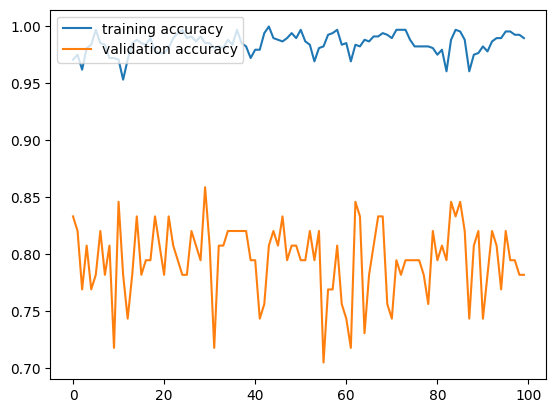

In [39]:
# Plotting the accuracy

plt.plot(history.history['accuracy'], label = "training accuracy")
plt.plot(history.history['val_accuracy'], label = "validation accuracy")
plt.legend(loc="upper left")

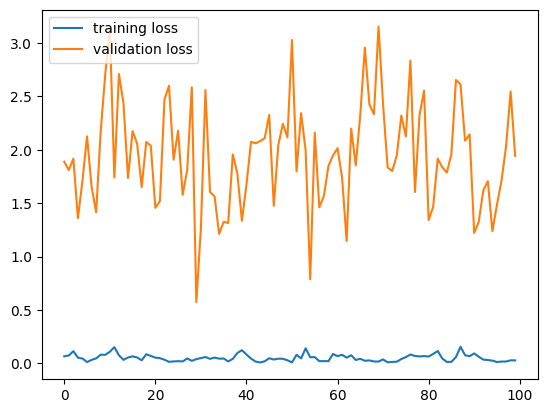

In [40]:
# Plotting the loss

plt.plot(history.history['loss'], label = "training loss")
plt.plot(history.history['val_loss'], label = "validation loss")
plt.legend(loc="upper left")

3/3 [==============================] - 0s 13ms/step
Accuracy test: 0.8787878787878788


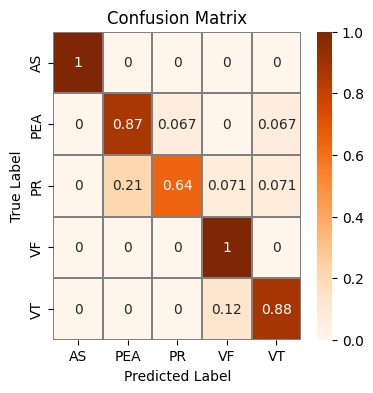

In [41]:
# Predicting of the model, using the test-set 
saved_model = load_model('best_model_category.h5')

# Prediction values
pred = saved_model.predict(X_test)

# Predict class
pred_max = np.argmax(pred, axis = 1) 

# Correct class
y_true = np.argmax(cat_test, axis = 1)

# The confusion matrix
conf_mtx = confusion_matrix(y_true, pred_max)

conf_mtx_norm = conf_mtx.astype('float') / conf_mtx.sum(axis=1)[:, np.newaxis]

f,ax = plt.subplots(figsize=(4, 4))
sns.heatmap(conf_mtx_norm, annot=True, linewidths=0.01, cmap='Oranges',linecolor='gray')
ax.xaxis.set_ticklabels(['AS', 'PEA', 'PR','VF', 'VT']); ax.yaxis.set_ticklabels(['AS', 'PEA', 'PR','VF', 'VT']);
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Accuracy of the prediction
acc_test = accuracy_score(y_true, pred_max)

print('Accuracy test:', acc_test)